In [75]:
import pandas as pd
import seaborn as sns
sns.set_palette('husl')
import matplotlib.pyplot as plt
%matplotlib inline
import hopsworks
from helper import *
from datetime import datetime

In [76]:
project = hopsworks.login()
fs = project.get_feature_store()

Connection closed.
Connected. Call `.close()` to terminate connection gracefully.

Logged in to project, explore it here https://c.app.hopsworks.ai:443/p/194708
Connected. Call `.close()` to terminate connection gracefully.


In [77]:
# Import the data that was obtained locally from running
df = pd.read_csv('incidents-v1.csv')

In [78]:
# Conver the startTime and endTime to datetime
df['startTime'] = pd.to_datetime(df['startTime'])
df['endTime'] = pd.to_datetime(df['endTime'])

In [79]:
# Get information about the data from the incidents
print(df.info())
print(df.describe())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1038 entries, 0 to 1037
Data columns (total 12 columns):
 #   Column            Non-Null Count  Dtype              
---  ------            --------------  -----              
 0   id                1038 non-null   object             
 1   code              1038 non-null   int64              
 2   description       1038 non-null   object             
 3   endTime           1038 non-null   datetime64[ns, UTC]
 4   hour              1038 non-null   int64              
 5   iconCategory      1038 non-null   int64              
 6   latitude          1038 non-null   float64            
 7   longitude         1038 non-null   float64            
 8   magnitudeOfDelay  1038 non-null   int64              
 9   month             1038 non-null   int64              
 10  startTime         1038 non-null   datetime64[ns, UTC]
 11  type              1038 non-null   object             
dtypes: datetime64[ns, UTC](2), float64(2), int64(5), object(3)
mem

In [80]:
# Add the duration column
df['duration'] = df['endTime'] - df['startTime']

0   0 days 01:06:35
1   0 days 01:24:06
2   0 days 01:34:06
3   0 days 01:34:06
4   0 days 01:05:06
Name: duration, dtype: timedelta64[ns]
0 days 16:26:14.104046242
10 days 06:22:24.345620809


(array([1.034e+03, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 1.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 3.000e+00]),
 array([3.7870000e+03, 7.9915900e+05, 1.5945310e+06, 2.3899030e+06,
        3.1852750e+06, 3.9806470e+06, 4.7760190e+06, 5.5713910e+06,
        6.3667630e+06, 7.1621350e+06, 7.9575070e+06, 8.7528790e+06,
        9.5482510e+06, 1.0343623e+07, 1.1138995e+07, 1.1934367e+07,
        1.2729739e+07, 1.3525111e+07, 1.4320483e+07, 1.5115855e+07,
        1.5911227e+07]),
 <BarContainer object of 20 artists>)

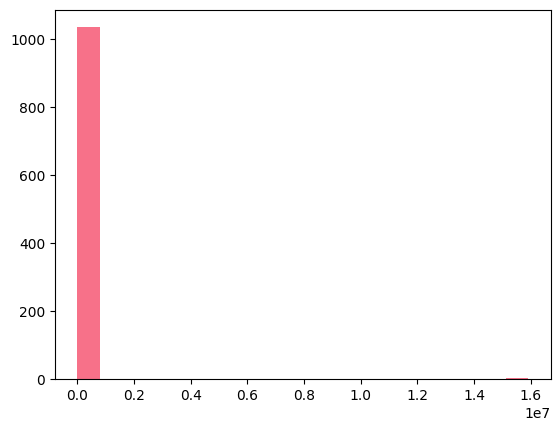

In [81]:
# Inspect the duration column
print(df['duration'].head())

# Print the mean and standard deviation of the duration
print(df['duration'].mean())
print(df['duration'].std())

# Plot the histogram of the duration
import matplotlib.pyplot as plt
plt.hist(df['duration'].dt.total_seconds(), bins=20)

1032


(array([793., 144.,  51.,  12.,   8.,   5.,   5.,   1.,   4.,   0.,   1.,
          1.,   0.,   2.,   0.,   0.,   1.,   0.,   0.,   4.]),
 array([ 3787.  ,  5014.75,  6242.5 ,  7470.25,  8698.  ,  9925.75,
        11153.5 , 12381.25, 13609.  , 14836.75, 16064.5 , 17292.25,
        18520.  , 19747.75, 20975.5 , 22203.25, 23431.  , 24658.75,
        25886.5 , 27114.25, 28342.  ]),
 <BarContainer object of 20 artists>)

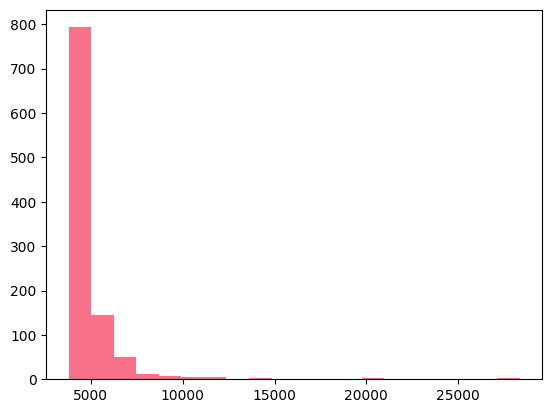

In [82]:
# We see that  there are outliers in the data. Let's remove them

df = df[df['duration'] < '1 days']
# Calculate the mean and standard deviation of the duration
mean = df['duration'].mean()
std = df['duration'].std()
print(len(df['duration']))

# Plot the histogram with the mean and standard deviation
plt.hist(df['duration'].dt.total_seconds(), bins=20)

In [83]:
# Make the column names lowercase
df.columns = df.columns.str.lower()

# Insert the dataframe into the feature store
primary_key = ['id']

# Conver the duration to seconds
df['duration'] = df['duration'].dt.total_seconds()

incidents_fg = fs.get_or_create_feature_group(
    name="sthlm_incidents",
    version=1,
    primary_key=primary_key, 
    description="Stockholm Incidents Dataset")
incidents_fg.insert(df)

Feature Group created successfully, explore it at 
https://c.app.hopsworks.ai:443/p/194708/fs/194627/fg/409977


Uploading Dataframe: 100.00% |██████████| Rows 1032/1032 | Elapsed Time: 00:05 | Remaining Time: 00:00


Launching job: sthlm_incidents_1_offline_fg_materialization
Job started successfully, you can follow the progress at 
https://c.app.hopsworks.ai/p/194708/jobs/named/sthlm_incidents_1_offline_fg_materialization/executions


(<hsfs.core.job.Job at 0x17db2fc9590>, None)